# Setting up DESI KP4 files for use in Barry
This notebook includes code to ingest all the files for DESI Y1 data and mocks, both Abacus and EZmocks, cutsky and cubic, and for multiple tracers and redshift bins. Barry has a strict set of data inputs, and everything gets pickled up into this format. This means the underlying clustering measurements etc., can be in any format.

Barry expects that you will read in/specify and pickle:
* Pre and post-recon data power spectrum with 5 multipoles (some multipoles can be set to zero if they are not required/measured). **Pre- and Post-recon currently set to None as there is no real data yet**
* N pre and post-recon mock power spectra with 5 multipoles (some can be set to zero if they are not required/measured). **Post-recon currently set to None as there is no post-recon mocks yet**
* Pre and post-recon covariance matrices for the power spectra (some elements/blocks can be set to zero if they are not required/measured) **Post-recon currently set to None as there is no post-recon mocks yet**
* A fiducial cosmology
* A window function convolution matrix (some elements/blocks can be set to the identify matrix if they are not required/measured), corresponding k-binning and integral constraint. Only needed for power spectra
* A compression matrix to convert the 3 even multipoles to 5 even+odd (can be given as a block identity matrix if you are not measuring odd multipoles). Only needed for power spectra.

Correlation functions are similar but a little simpler (only 3 multipoles, and no window function stuff).

The code below reads in all the files for both Abacus and EZmocks for LRGs. Hopefully it can be easily extended to do other tracers and redshift bins. As there is currently no real data, so we just parcel up all the mock measurements and covariance matrices. This is still enough to enable fits to the mock means, and individual realisations.

In [20]:
# Import the necessary packages
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
# General routines for reading input files, power spectrum, covariance matrix, window function matrix, or odd multipole computa matrix

# Correlation function.
def getxi(loc, zname):
    sin = pd.read_csv(loc+"/s.txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T[0]
    ximat = [pd.read_csv(loc+f"/Xi_{ell}"+zname+".txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T for ell in [0,2,4]]
    
    res = []
    nmocks = np.shape(ximat[0])[0]
    for i in range(nmocks):
        df = {}
        df["s"] = sin
        for l, ell in enumerate([0, 2, 4]):
            df[f"xi{ell}"] = ximat[l][i]
        res.append(pd.DataFrame(df))
        
    return res

# Power Spectrum. Barry needs 5 even+odd multipoles, but the odd ones can be filled with zeros if these haven't been measured, as is done here.
def getpk(loc, zname):
    kin = pd.read_csv(loc+"/k.txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T[0]
    pkmat = [pd.read_csv(loc+f"/Pk_{ell}"+zname+".txt", comment="#", skiprows=0, delim_whitespace=True, header=None).to_numpy().T for ell in [0,2,4]]
    
    res = []
    nmocks = np.shape(pkmat[0])[0]
    for i in range(nmocks):
        df = {}
        df["k"] = kin
        for l, ell in enumerate([0, 2, 4]):
            df[f"pk{ell}"] = pkmat[l][i]
        df["pk1"] = np.zeros(len(df["k"]))
        df["pk3"] = np.zeros(len(df["k"]))
        res.append(pd.DataFrame(df))
        
    return res

# Window function matrix. The window functions are stored in a dictionary of 'step sizes' i.e., how many bins get stuck together relative to the 
# pk measurements so that we can rebin the P(k) at run time if required. Each step size is a dictionary with:
#    the input and output k binning (w_ks_input, w_ks_output), the window function matrix (w_transform) and integral constraint (w_k0_scale).
# The window function assumes 5 input and output multipoles. For cubic sims, we can set the integral constraint to zero and window matrix to the identity matrix, as is done here.
def getwin_dummy(ks):
    res = {"w_ks_input": ks.copy(), "w_k0_scale": np.zeros(ks.size), "w_transform": np.eye(5 * ks.size), "w_ks_output": ks.copy()}
    return {1: res}  # Step size is one

# The conversion matrix M from Beutler 2019. Used to compute the odd multipole models given the even multipoles. In the absence of wide angle effects, or if we don't care about
# the odd multipoles, we can set this to a block matrix with identity matrices in the appropriate places, as is done here.
def getcomp_dummy(ks):
    matrix = np.zeros((5 * ks.size, 3 * ks.size))
    matrix[: ks.size, : ks.size] = np.diag(np.ones(ks.size))
    matrix[2 * ks.size : 3 * ks.size, ks.size : 2 * ks.size] = np.diag(np.ones(ks.size))
    matrix[4 * ks.size :, 2 * ks.size :] = np.diag(np.ones(ks.size))
    return matrix

# Power spectrum covariance matrix. Needs to have 5 multipoles, but if the some of them haven't been measured, we can set the covariance matrix elements to zero, as is done here.
def format_pk_cov(nks, covfile):

    cov_input = pd.read_csv(covfile, comment="#", delim_whitespace=True, header=None).to_numpy()
    nin = nks
    cov = np.zeros((5 * nks, 5 * nks))
    cov[:nks, :nks] = cov_input[:nks, :nks]
    cov[:nks, 2 * nks : 3 * nks] = cov_input[:nks, nin : nin + nks]
    cov[:nks, 4 * nks :] = cov_input[:nks, 2 * nin : 2 * nin + nks]
    cov[2 * nks : 3 * nks, :nks] = cov_input[nin : nin + nks, :nks]
    cov[2 * nks : 3 * nks, 2 * nks : 3 * nks] = cov_input[nin : nin + nks, nin : nin + nks]
    cov[2 * nks : 3 * nks, 4 * nks :] = cov_input[nin : nin + nks, 2 * nin : 2 * nin + nks]
    cov[4 * nks :, :nks] = cov_input[2 * nin : 2 * nin + nks, :nks]
    cov[4 * nks :, 2 * nks : 3 * nks] = cov_input[2 * nin : 2 * nin + nks, nin : nin + nks]
    cov[4 * nks :, 4 * nks :] = cov_input[2 * nin : 2 * nin + nks, 2 * nin : 2 * nin + nks]
    
    return cov

# Correlation function covariance matrix.
def format_xi_cov(nss, covfile):

    cov_input = pd.read_csv(covfile, comment="#", delim_whitespace=True, header=None).to_numpy()
    nin = nss
    cov = np.zeros((3 * nss, 3 * nss))
    cov[:nss, :nss] = cov_input[:nss, :nss]
    cov[:nss, nss : 2 * nss] = cov_input[:nss, nin : nin + nss]
    cov[:nss, 2 * nss :] = cov_input[:nss, 2 * nin : 2 * nin + nss]
    cov[nss : 2 * nss, :nss] = cov_input[nin : nin + nss, :nss]
    cov[nss : 2 * nss, nss : 2 * nss] = cov_input[nin : nin + nss, nin : nin + nss]
    cov[nss : 2 * nss, 2 * nss :] = cov_input[nin : nin + nss, 2 * nin : 2 * nin + nss]
    cov[2 * nss :, :nss] = cov_input[2 * nin : 2 * nin + nss, :nss]
    cov[2 * nss :, nss : 2 * nss] = cov_input[2 * nin : 2 * nin + nss, nin : nin + nss]
    cov[2 * nss :, 2 * nss :] = cov_input[2 * nin : 2 * nin + nss, 2 * nin : 2 * nin + nss]
    
    return cov

# Useful utility function to collate some Pk data
def collect_pk_data(pre_files, post_files, zeff, zname, name):
    
    pre_res = getpk(pre_files, zname)
    #post_res = getpk(post_files, zname)
    
    ks = pre_res[0]["k"].to_numpy()
    
    pre_cov = format_pk_cov(len(ks), pre_files + "cov" + zname + ".txt")
    #post_cov = format_pk_cov(len(ks), post_files + "cov" + zname + ".txt")

    split = {
        "pre-recon data": None,
        "pre-recon cov": pre_cov,
        "post-recon data": None,
        "post-recon cov": None,
        "pre-recon mocks": [v for v in pre_res],
        "post-recon mocks": None,
        "cosmology": {
            "om": (0.1188 + 0.02230 + 0.00064) / 0.6774 ** 2,
            "h0": 0.6774,
            "z": zeff,
            "ob": 0.02230 / 0.6774 ** 2,
            "ns": 0.9667,
            "mnu": 0.00064 * 93.14,
            "reconsmoothscale": 15,
        },
        "name": name,
        "winfit": getwin_dummy(ks),
        "winpk": None,  # We can set this to None; Barry will set it to zeroes given the length of the data vector.
        "m_mat": getcomp_dummy(ks),
    }
    
    with open(f"../" + name.lower().replace(" ", "_")+".pkl", "wb") as f:
        pickle.dump(split, f)
        
    return split

# Useful utility function to collate some Xi data
def collect_xi_data(pre_files, post_files, zeff, zname, name):

    pre_res = getxi(pre_files, zname)
    #post_res = getxi(post_files, zname)
    
    ss = pre_res[0]["s"].to_numpy()
    
    pre_cov = format_xi_cov(len(ss), pre_files + "cov" + zname + ".txt")
    #post_cov = format_xi_cov(len(ss), post_files + "cov" + zname + ".txt")

    split = {
        "pre-recon data": None,
        "pre-recon cov": pre_cov,
        "post-recon data": None,
        "post-recon cov": None,
        "pre-recon mocks": [v for v in pre_res],
        "post-recon mocks": None,
        "cosmology": {
            "om": (0.1188 + 0.02230 + 0.00064) / 0.6774 ** 2,
            "h0": 0.6774,
            "z": zeff,
            "ob": 0.02230 / 0.6774 ** 2,
            "ns": 0.9667,
            "mnu": 0.00064 * 93.14,
            "reconsmoothscale": 15,
        },
        "name": name,
    }
    
    with open(f"../" + name.lower().replace(" ", "_")+".pkl", "wb") as f:
        pickle.dump(split, f)
        
    return split

# Plot the power spectra, for sanity checking
def plot_pk(split):
    
    color = ["r", "b", "g"]
    ks = split["pre-recon mocks"][0]["k"]
    nmocks = len(split["pre-recon mocks"])
    label = [r"$P_{0}(k)$", r"$P_{2}(k)$", r"$P_{4}(k)$"]
    for m, pk in enumerate(["pk0", "pk2", "pk4"]):
        yerr = ks * np.sqrt(np.diag(split["pre-recon cov"]))[2 * m * len(ks) : (2 * m + 1) * len(ks)]
        plt.errorbar(
            ks,
            ks * np.mean([split["pre-recon mocks"][i][pk] for i in range(nmocks)], axis=0),
            yerr=yerr,
            marker="o",
            ls="None",
            c=color[m],
            label=label[m],
        )
        for i in range(nmocks):
            plt.errorbar(ks, ks * split["pre-recon mocks"][i][pk], marker="None", ls="-", c='k', alpha=0.1)
    plt.xlabel(r"$k$")
    plt.ylabel(r"$k\,P(k)$")
    plt.title(split["name"])
    plt.legend()
    plt.show()
    
# Plot the power spectra, for sanity checking
def plot_xi(split):
    
    color = ["r", "b", "g"]
    ss = split["pre-recon mocks"][0]["s"]
    nmocks = len(split["pre-recon mocks"])
    label = [r"$\xi_{0}(k)$", r"$\xi_{2}(k)$", r"$\xi_{4}(k)$"]
    for m, xi in enumerate(["xi0", "xi2", "xi4"]):
        yerr = ss ** 2 * np.sqrt(np.diag(split["pre-recon cov"]))[m * len(ss) : (m + 1) * len(ss)]
        plt.errorbar(
            ss,
            ss ** 2 * np.mean([split["pre-recon mocks"][i][xi] for i in range(nmocks)], axis=0),
            yerr=yerr,
            marker="o",
            ls="None",
            c=color[m],
            label=label[m],
        )
        for i in range(nmocks):
            plt.errorbar(ss, ss ** 2 * split["pre-recon mocks"][i][xi], marker="None", ls="-", c='k', alpha=0.1)
    plt.xlabel(r"$s$")
    plt.ylabel(r"$s^{2}\,\xi(s)$")
    plt.title(split["name"])
    plt.legend()
    plt.show()
    
# A useful sort function
def sortfunc(item):
    if "Abacus" in item:
        return int(item.split("_")[7][2:])
    else:
        return int(item.split("_")[11] if "recon" in item else item.split("_")[9])

# Abacus Cubic Mocks

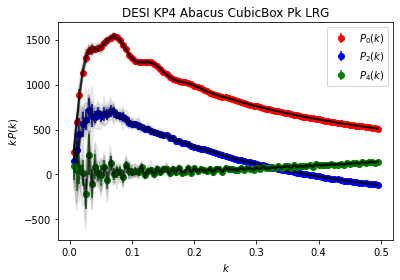

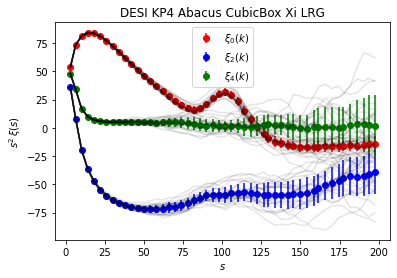

In [22]:
# Loop over tracers
path = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CubicBox/"
for tracer in ["LRG"]:
    
    # Power Spectrum
    pre_file = path + "Pk/jmena/nmesh_512/dk0.005/"
    name = f"DESI KP4 Abacus CubicBox Pk " + tracer
    data = collect_pk_data(pre_file, None, 0.8, "", name)
    plot_pk(data) # Plot the data to check things
   
    # Correlation Function
    pre_file = path + "Xi/jmena/"
    name = f"DESI KP4 Abacus CubicBox Xi " + tracer
    data = collect_xi_data(pre_file, None, 0.8, "", name)
    plot_xi(data) # Plot the data to check things

# Abacus CutSky Mocks

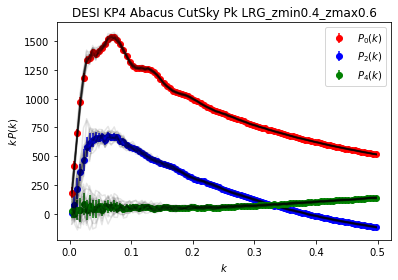

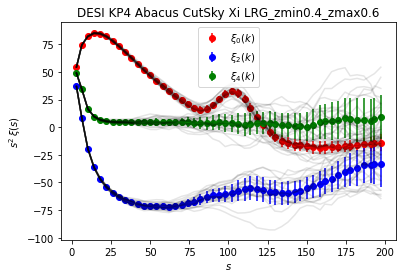

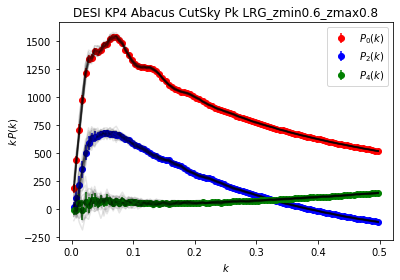

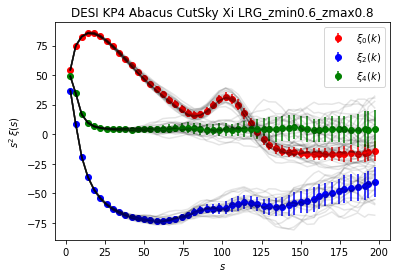

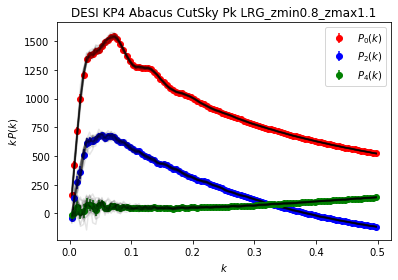

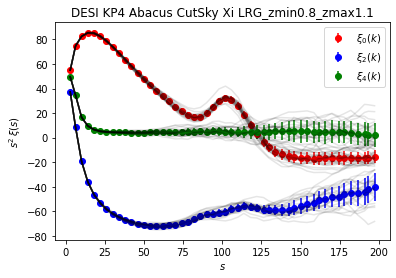

In [23]:
# Loop over tracers and redshift bins
path = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/AbacusSummit/CutSky/"

# Dictionary containing zmin, zmax and zeff for the tracers
reds = {"LRG": [["0.4", "0.6", 0.5], ["0.6", "0.8", 0.7], ["0.8", "1.1", 0.95]]}

for tracer in ["LRG"]:
    for i, (zmin, zmax, zeff) in enumerate(reds[tracer]):
        
        # Power Spectrum
        pre_file = path + tracer + "/Pk/jmena/nmesh_1024/dk0.005/"
        zname = "_zmin" + zmin + "_zmax" + zmax
        name = f"DESI KP4 Abacus CutSky Pk " + tracer + zname
        data = collect_pk_data(pre_file, None, zeff, zname, name)
        plot_pk(data) # Plot the data to check things

        # Correlation Function
        pre_file = path + tracer + "/Xi/jmena/"
        zname = "_zmin" + zmin + "_zmax" + zmax
        name = f"DESI KP4 Abacus CutSky Xi " + tracer + zname
        data = collect_xi_data(pre_file, None, zeff, zname, name)
        plot_xi(data) # Plot the data to check things

# EZmocks CutSky

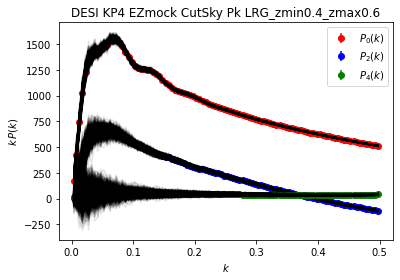

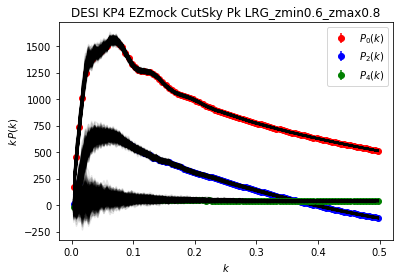

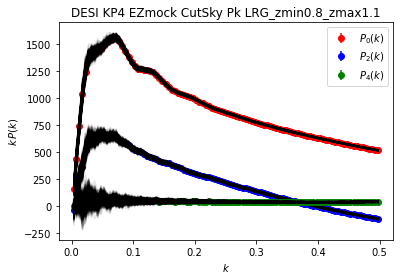

In [24]:
# Loop over tracers and redshift bins
path = "/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/EZmock/CutSky/"

# Dictionary containing zmin, zmax and zeff for the tracers
reds = {"LRG": [["0.4", "0.6", 0.5], ["0.6", "0.8", 0.7], ["0.8", "1.1", 0.95]]}

for tracer in ["LRG"]:
    for i, (zmin, zmax, zeff) in enumerate(reds[tracer]):
                
        # Power Spectrum
        pre_file = path + tracer + "/Pk/jmena/nmesh_1024/dk0.005/"
        zname = "_zmin" + zmin + "_zmax" + zmax
        name = f"DESI KP4 EZmock CutSky Pk " + tracer + zname
        data = collect_pk_data(pre_file, None, zeff, zname, name)
        plot_pk(data) # Plot the data to check things

        # Correlation Function
        #pre_file = path + tracer + "/Xi/jmena/"
        #zname = "_zmin" + zmin + "_zmax" + zmax
        #name = f"DESI KP4 EZmock CutSky Pk " + tracer + zname
        #data = collect_pk_data(pre_file, None, zeff, zname, name)
        #plot_pk(data) # Plot the data to check things